<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp2/ML_TP2_Data_wrangling_and_minimum_error_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML TP2 - Data wrangling and minimum error classifiers

In [ ]:
#@title Imports

# Install and import wget
!pip install wget
import wget

# Import numpy
import numpy as np

# Import matplotlib
from matplotlib import pyplot as plt

# Import pandas
import pandas as pd

# Import seaborn
import seaborn as sns 

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=79ad7c6b4dae779bf62739282eb3e17b670ccd9e5a7f9965374515720cecaab8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


##Ejercicio 1: Data wrangling

Dataset de la situación epidemiológica y sanitaria relacionada con el covid en Bahía Blanca en los últimos meses (fuente https://datos.bahia.gob.ar/dataset?groups=covid19).

https://github.com/manlio99/Materia-deaprendizaje/blob/master/4_DataWrangling/data/casos_covid_bahia.csv
y https://github.com/manlio99/Materia-deaprendizaje/blob/master/4_DataWrangling/data/camas_covid_bahia.csv

Las variables son discretas (personas) pero se puede aplicar razonablemente el análisis estadístico como si fuesen valores continuos.

Hay variables que puedan ser razonablemente consideradas normales? Hay variables
que tienen un comportamiento sospechoso?

In [ ]:
#@title Obtener datos

# Clean local raw data folder
!rm -rf raw
!mkdir raw

def get_raw_data():
  '''
  Download datasets and store in raw format
  '''
  
  # Beds dataset
  url = "https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/4_DataWrangling/data/camas_covid_bahia.csv"
  wget.download(url, out = "./raw/camas.csv")

  # Cases dataset 
  url = "https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/4_DataWrangling/data/casos_covid_bahia.csv"
  wget.download(url, out = "./raw/casos.csv")

get_raw_data()

df_camas = pd.read_csv("./raw/camas.csv")
df_casos = pd.read_csv("./raw/casos.csv")


#### Dataset Camas

Analizando la información de los dataframe:

- Todos son int64 excepto fecha y observaciones. 
- Observaciones tiene 8 valores no nulos
- La fecha no es tipo DateTime (probablemente string)

In [ ]:
print("Camas:")
df_camas.info()

Camas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   informeNumero                          88 non-null     int64 
 1   fecha                                  88 non-null     object
 2   total_camas_hospitales                 88 non-null     int64 
 3   camas_ocupadas_hospitales              88 non-null     int64 
 4   porcentaje_ocupacion_camas_hospitales  88 non-null     int64 
 5   camas_covid                            88 non-null     int64 
 6   camas_sospechosos_covid                88 non-null     int64 
 7   camas_confirmados_covid                88 non-null     int64 
 8   porcentaje_ocupacion_camas_covid       88 non-null     int64 
 9   uti_covid_totales                      88 non-null     int64 
 10  uti_covid_ocupadas                     88 non-null     int64 
 11  respiradores_t

Convertimos la columna "fecha" a date time "dt" y la definimos como índice. Luego descartamos la columna "fecha"

In [ ]:
#@title Conversion de fechas

def dt_to_index(df:pd.DataFrame,datecol:str, format:str) -> pd.DataFrame:
  '''
  Creates a date time column using a string column with the specified format
  Drops string column
  Sets date time column as index
  '''
  df['dt'] =  pd.to_datetime(df[datecol], format=format)
  df.index = df['dt']
  df = df.drop(columns=["fecha"])
  return df

#Convert fecha to datetime column 
df_camas= dt_to_index(df_camas,'fecha','%Y-%m-%d')


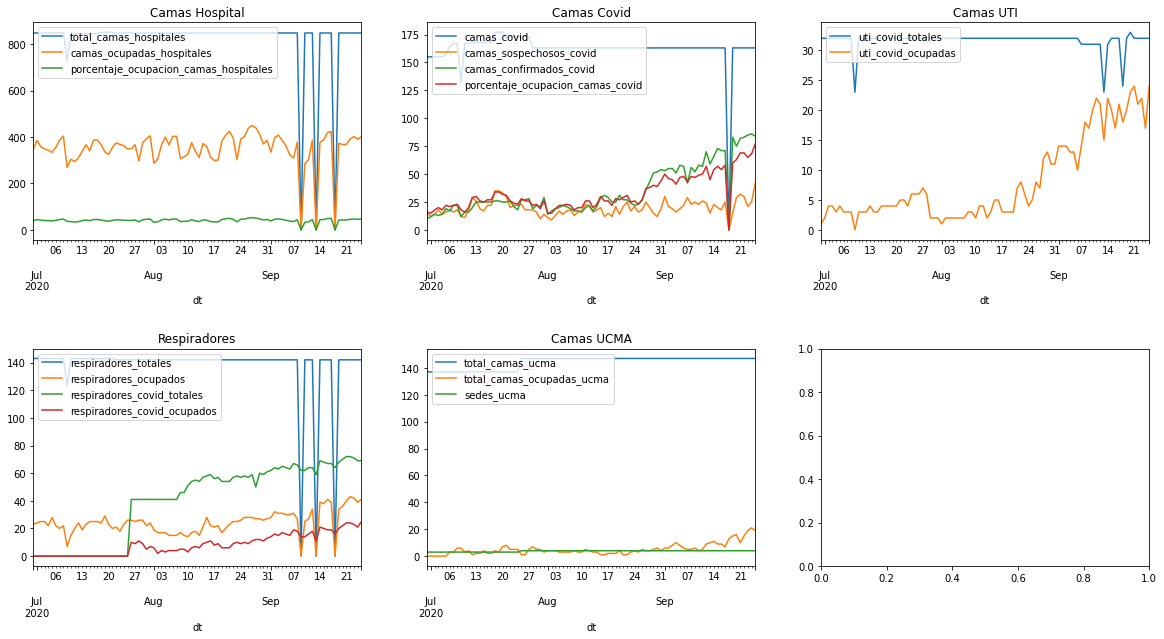

In [ ]:
#@title Plot Dataset Camas Inicial

# Create figure
fig, axes = plt.subplots(2,3)
fig.set_size_inches(20,10)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

def plot_df(title,x,y,df,ax):
  df.plot(x=x,y=y,ax=ax)
  ax.set_title(title)
  ax.legend( loc='upper left')

# Plot Hospital beds
plot_df("Camas Hospital",
        'dt',
        ['total_camas_hospitales','camas_ocupadas_hospitales','porcentaje_ocupacion_camas_hospitales'],
        df_camas,
        axes[0,0])

# Plot Covid beds
plot_df("Camas Covid",
        'dt',
        ['camas_covid','camas_sospechosos_covid','camas_confirmados_covid','porcentaje_ocupacion_camas_covid'],
        df_camas,
        axes[0,1])

# Plot UTI beds
plot_df("Camas UTI",
        'dt',
        ['uti_covid_totales','uti_covid_ocupadas'],
        df_camas,
        axes[0,2])

# Plot Respiradores
plot_df("Respiradores",
        'dt',
        ['respiradores_totales','respiradores_ocupados','respiradores_covid_totales','respiradores_covid_ocupados'],
        df_camas,
        axes[1,0])

# Plot UCMA
plot_df("Camas UCMA",
        'dt',
        ['total_camas_ucma','total_camas_ocupadas_ucma','sedes_ucma'],
        df_camas,
        axes[1,1])



Al graficar el dataset de camas observamos algunos algunos problemas con los registros. Hay al menos 4 fechas con datos faltantes que será necesario corregir. 
Si filtramos esos días vemos que en la columna de observaciones que hubo algún problema en la información 

In [ ]:
print(df_camas[df_camas["total_camas_hospitales"] <= 800]['observaciones'])

dt
2020-09-18    Sin información del Hospital Municipal. \nPor ...
2020-09-13    - El Hospital Municipal no brindó información ...
2020-09-09    Sin información del total de camas y del total...
2020-07-09    No se recibió informe de camas, camas UTI y re...
Name: observaciones, dtype: object


Veamos que otras observaciones hay en el dataset:

In [ ]:
print(df_camas[df_camas["observaciones"].notnull()]['observaciones'])

dt
2020-09-18    Sin información del Hospital Municipal. \nPor ...
2020-09-13    - El Hospital Municipal no brindó información ...
2020-09-11                    Hospital Penna informó solo COVID
2020-09-10    Sin información del total de camas y del total...
2020-09-09    Sin información del total de camas y del total...
2020-08-02                          SIN INFORMACIÓN DEL ESPAÑOL
2020-08-01    POR FALTA DE LUZ, EL HMALL NO PUDO INFORMAR OC...
2020-07-09    No se recibió informe de camas, camas UTI y re...
Name: observaciones, dtype: object


La información de esos días no es confiable, por lo que se decide reemplazarla por la del día anterior 

In [ ]:
# Set to na all non trustable values 
df_camas[df_camas["observaciones"].notnull()] = np.nan

# Fill with last good value
df_camas_clean = df_camas.bfill()



También la atención el salto en las variables *respiradores_covid_totales* y *respiradores_covid_ocupados* a fines de Julio. Posiblemente, al tratarse de un subconjunto de los respiradores totales, no se estuviera informando hasta ese momento. Se cmpletan los valores faltantes hacia atrás con el primer valor válido.

In [ ]:
# Set to na all 0 values
cols = ["respiradores_covid_totales","respiradores_covid_ocupados"]
df_camas_clean[cols] = df_camas_clean[cols].replace(0, np.nan)

# Fill with first next good value
df_camas_clean=df_camas_clean.ffill()

Finalmente descartamos la columna observaciones.

In [ ]:
df_camas_clean = df_camas_clean.drop(columns=['observaciones'])

In [ ]:
df_camas_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2020-09-25 to 2020-06-30
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   informeNumero                          88 non-null     float64       
 1   total_camas_hospitales                 88 non-null     float64       
 2   camas_ocupadas_hospitales              88 non-null     float64       
 3   porcentaje_ocupacion_camas_hospitales  88 non-null     float64       
 4   camas_covid                            88 non-null     float64       
 5   camas_sospechosos_covid                88 non-null     float64       
 6   camas_confirmados_covid                88 non-null     float64       
 7   porcentaje_ocupacion_camas_covid       88 non-null     float64       
 8   uti_covid_totales                      88 non-null     float64       
 9   uti_covid_ocupadas                     88 non-n

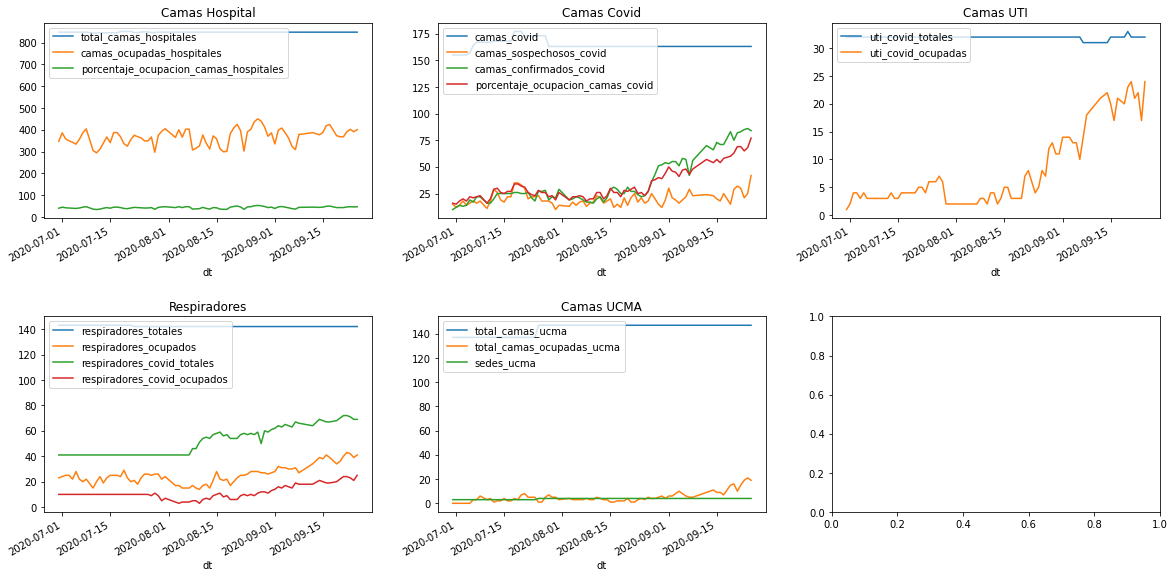

In [ ]:
#@title Plot Dataset Camas Limpio

# Create figure
fig, axes = plt.subplots(2,3)
fig.set_size_inches(20,10)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

def plot_df(title,x,y,df,ax):
  df.plot(x=x,y=y,ax=ax)
  ax.set_title(title)
  ax.legend( loc='upper left')

# Plot Hospital beds
plot_df("Camas Hospital",
        'dt',
        ['total_camas_hospitales','camas_ocupadas_hospitales','porcentaje_ocupacion_camas_hospitales'],
        df_camas_clean,
        axes[0,0])

# Plot Covid beds
plot_df("Camas Covid",
        'dt',
        ['camas_covid','camas_sospechosos_covid','camas_confirmados_covid','porcentaje_ocupacion_camas_covid'],
        df_camas_clean,
        axes[0,1])

# Plot UTI beds
plot_df("Camas UTI",
        'dt',
        ['uti_covid_totales','uti_covid_ocupadas'],
        df_camas_clean,
        axes[0,2])


# Plot Respiradores
plot_df("Respiradores",
        'dt',
        ['respiradores_totales','respiradores_ocupados','respiradores_covid_totales','respiradores_covid_ocupados'],
        df_camas_clean,
        axes[1,0])

# Plot UCMA
plot_df("Camas UCMA",
        'dt',
        ['total_camas_ucma','total_camas_ocupadas_ucma','sedes_ucma'],
        df_camas,
        axes[1,1])



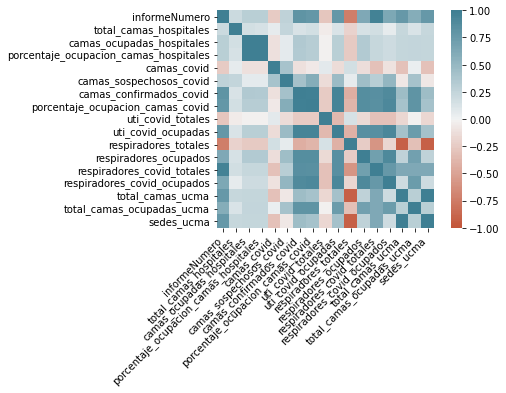

In [ ]:
#@title Correlacion Dataset Camas
corr = df_camas_clean.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Del grafico puede observarse:
* `informeNumero` tiene una alta correlacion con varias variables, como por ejemplo `camas_confirmados_covid`. Esto puede ser engañoso, dado que ambas variables crecen en el tiempo (la primera porque se trata de una secuencia numerica, y la segunda por el aumento de casos) no implica que haya una relación de causalidad entre ellas.
* Hay un grupo de variables (`total_camas_hospitales`, `camas_ocupadas_hospitales`,`porcentaje_ocupacion_camas_hospitales`,`camas_covid`,`camas_sospechosos _covid`,`uti_covid_totales`) que tienen poca correlacion con el resto. Son variables que se mantienen constantes en el tiempo (no tienen una tendencia definida)
* Los porcentajes (`porcentaje_ocupacion_camas_hospitales`,`porcentaje_ocupacion_camas_covid`) tienen una alta correlacion con la cantidad de camas ocupadas (`camas_ocupadas_hospitales`,`camas_confirmados_covid`). Esto es esperable porque el total de camas es aprximadamente constante, y el porcentaje se calcula a partir de las camas ocupadas.
* Parece haber una correlacion negativa fuerte entre `respiradores_totales` y `total_camas_ocupadas_ucma` asi como con `sedes_ucma`

A continuación se realiza un scatterplot de las variables. Es interesante ver que `camas_sospechosos_covid` presenta distribuciones más dispersas que el resto de las variables.

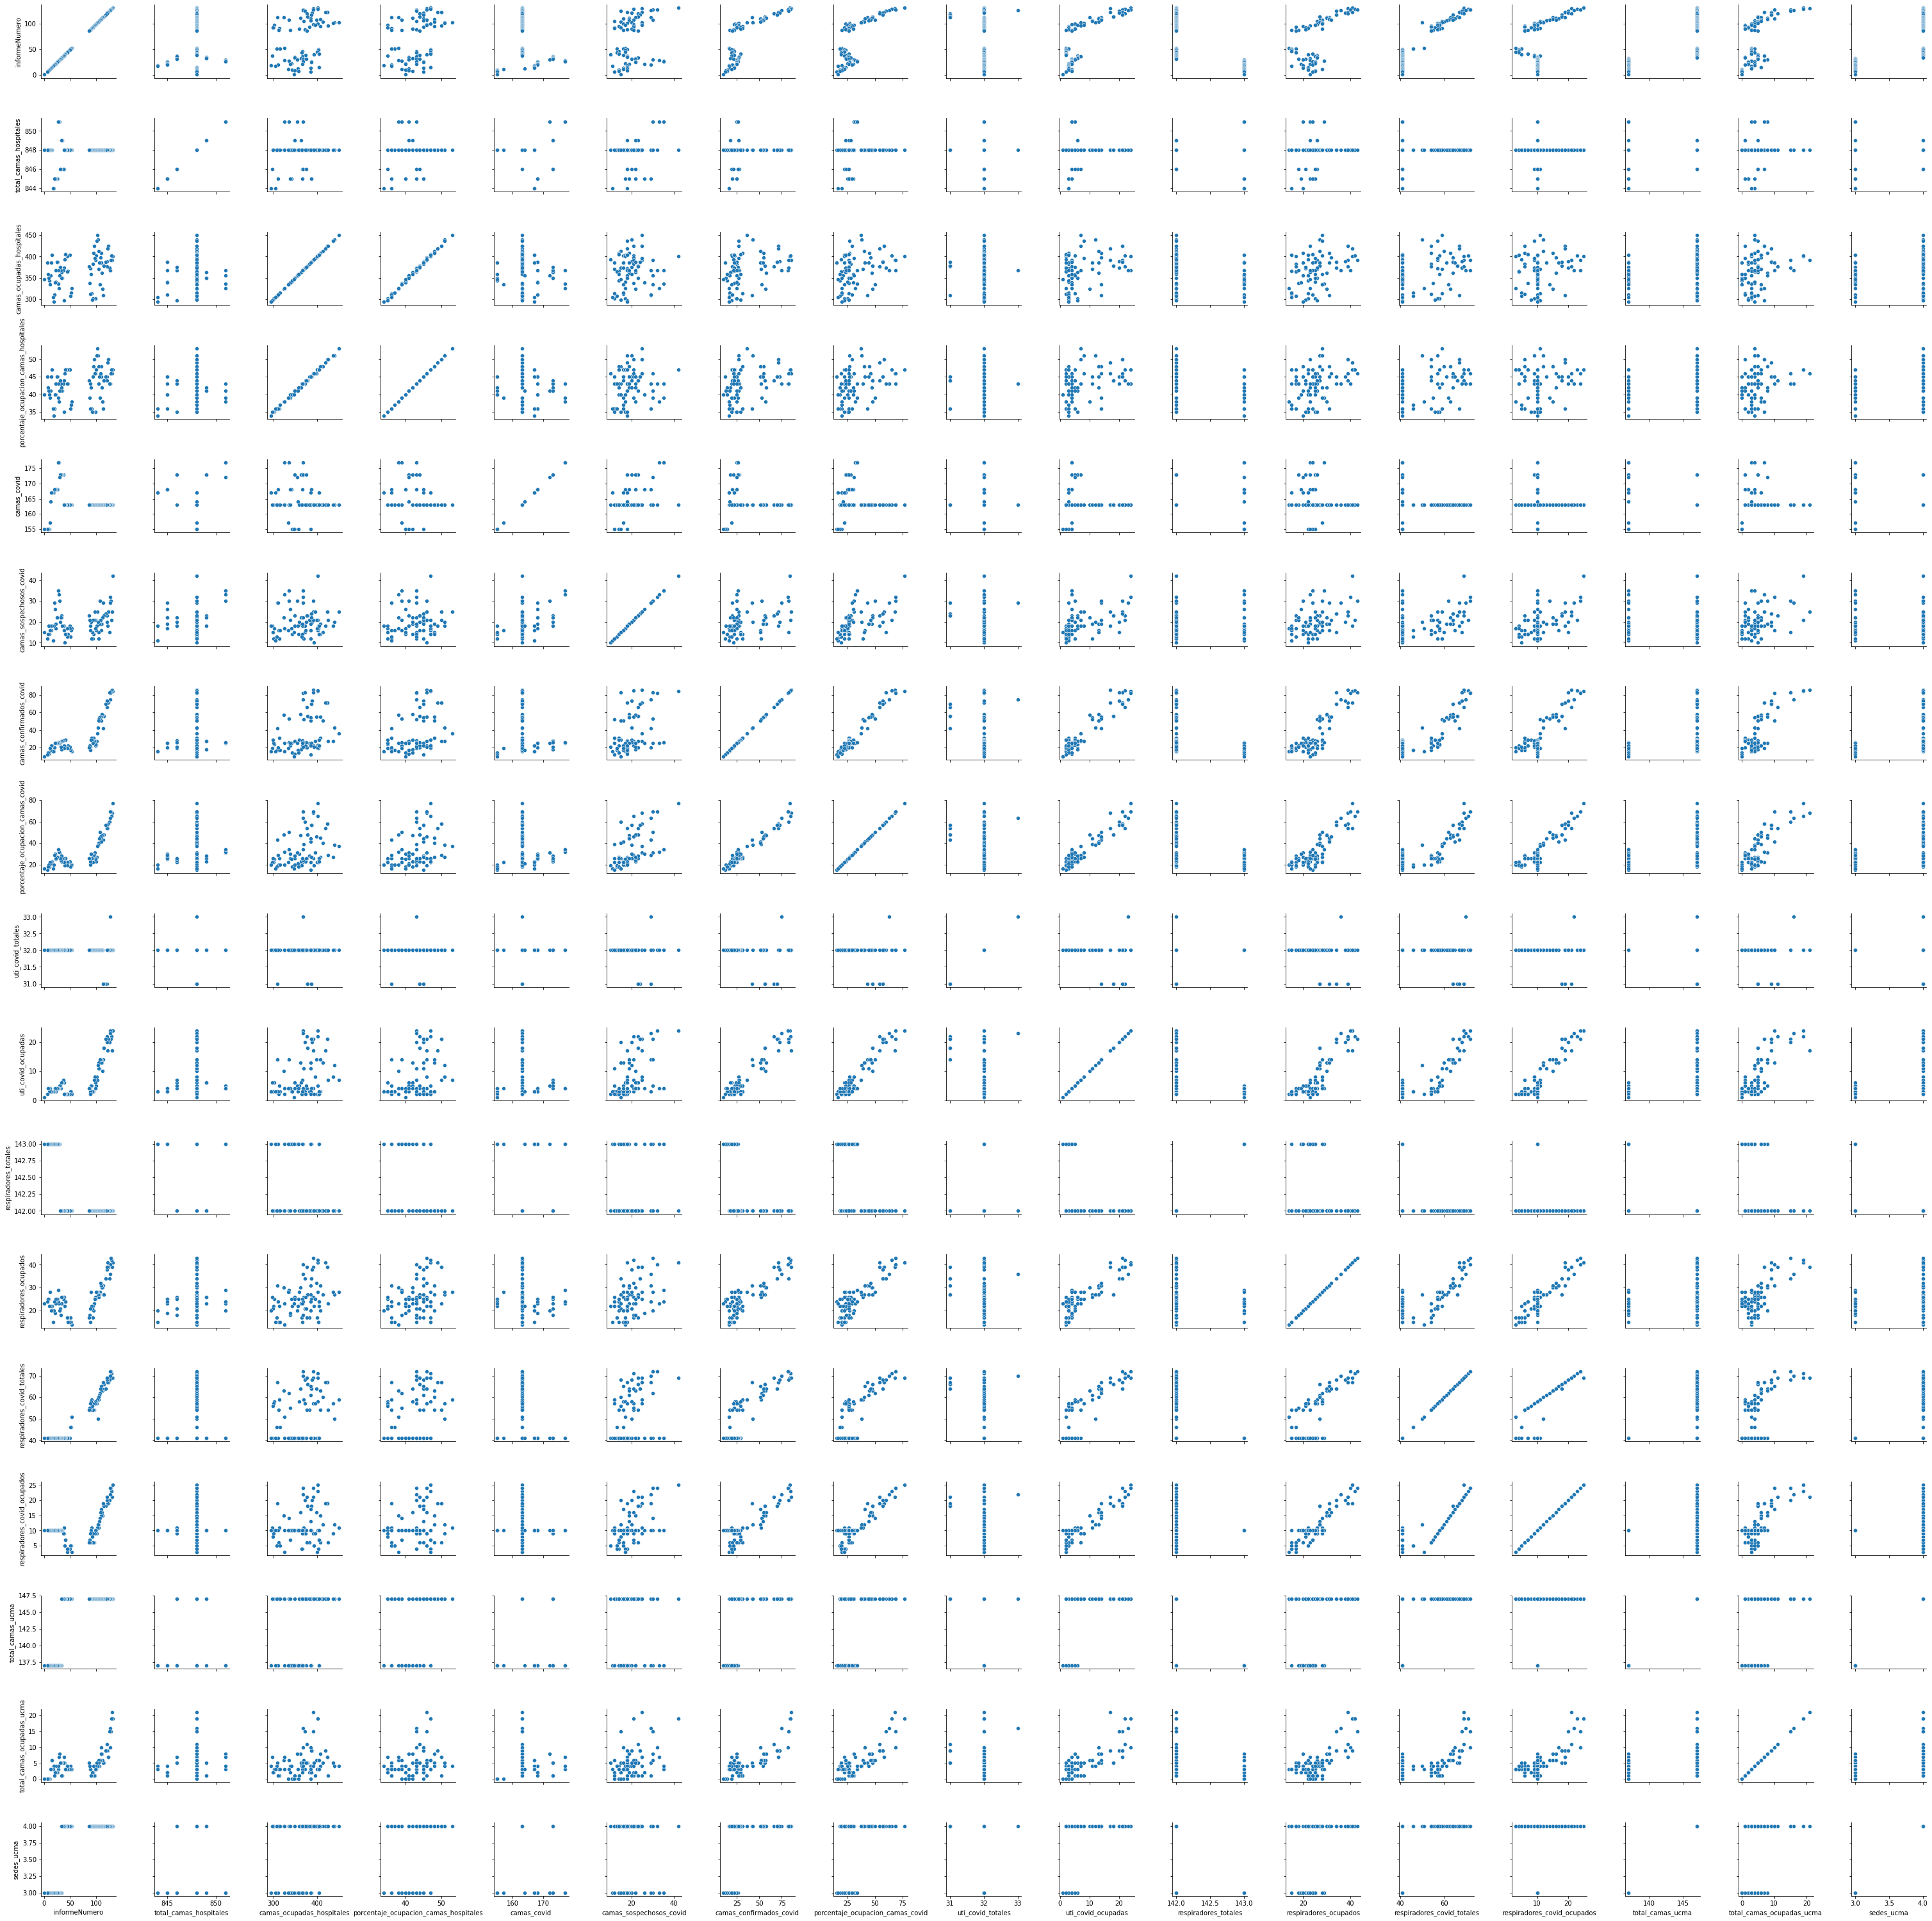

In [ ]:
#@title Scatterplots Dataset Camas
g = sns.PairGrid(df_camas_clean)
g.map(sns.scatterplot)

Del Scatterplot puede apreciarse con más detalle lo observado en la matriz de correlación. Se aprecia además que varias variables, a pesar de ser numéricas toman valores discretos (por ejemplo: `sedes_ucma`, `uti_covid`). Se verifica que relaciones muy fuertes de linealidad entre los porcentajes y las ocupaciones asociadas. Posiblemente sea necesario descartar una u otra variable. 

####Dataset Casos

En primer lugar llama la atención la columna `aprehendidos `cuyo valor es siempre 0. Por otro lado `contencion_psicológica `adquiere solo algunos valores discretos, por lo que sus percentiles y su máximo coinciden.

In [ ]:
df_casos.describe()

,confirmados,activos,recuperados,decesos,descartados,sospechosos,contencion_psicologica,monitoreo_epidemiologico,aislamiento_por_contacto_estrecho,aprehendidos
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0
mean,944.977273,403.738636,516.238636,25.000000,2007.647727,157.613636,407.295455,1360.386364,287.920455,0.0
std,741.951512,377.382561,369.502430,16.613248,951.537510,101.144080,21.174241,289.810181,113.161691,0.0
min,106.000000,29.000000,71.000000,6.000000,574.000000,22.000000,342.000000,1014.000000,169.000000,0.0
25%,422.000000,201.250000,164.000000,13.000000,1159.250000,96.000000,417.000000,1215.000000,206.250000,0.0
50%,706.500000,238.000000,502.000000,20.000000,1999.500000,122.000000,417.000000,1280.000000,246.500000,0.0
75%,1262.750000,487.750000,742.250000,32.750000,2794.500000,232.250000,417.000000,1374.750000,370.500000,0.0
max,3012.000000,1512.000000,1434.000000,66.000000,3738.000000,382.000000,417.000000,2377.000000,625.000000,0.0


No se obervan valores faltantes en este caso

In [ ]:
df_casos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   fecha                              88 non-null     object
 1   confirmados                        88 non-null     int64 
 2   activos                            88 non-null     int64 
 3   recuperados                        88 non-null     int64 
 4   decesos                            88 non-null     int64 
 5   descartados                        88 non-null     int64 
 6   sospechosos                        88 non-null     int64 
 7   contencion_psicologica             88 non-null     int64 
 8   monitoreo_epidemiologico           88 non-null     int64 
 9   aislamiento_por_contacto_estrecho  88 non-null     int64 
 10  aprehendidos                       88 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 7.7+ KB


In [ ]:
#@title Conversion de fechas
df_casos= dt_to_index(df_casos,'fecha','%Y-%m-%d')

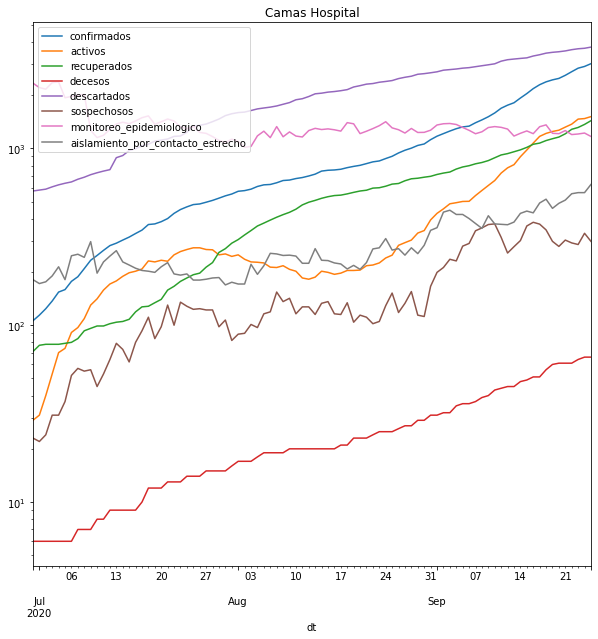

In [ ]:
#@title Grafico temporal Dataset Casos

# Create figure

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_yscale('log')

# Plot Hospital beds
plot_df("Camas Hospital",
        'dt',
        ['confirmados','activos','recuperados','decesos','descartados','sospechosos','monitoreo_epidemiologico','aislamiento_por_contacto_estrecho'],
        df_casos,
        ax)


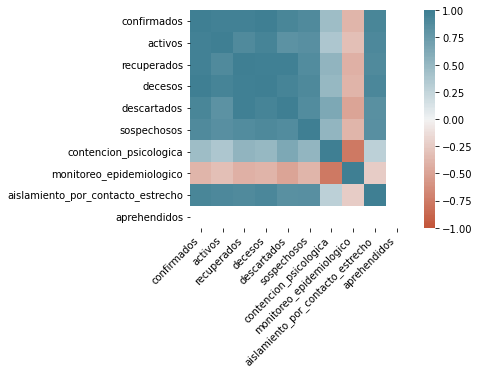

In [ ]:
#@title Correlacion Dataset Casos
corr = df_casos.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, xticklabels=True, yticklabels=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Del gráfico se observan fuertes correlaciones entre todas las variables, salvo `monitoreo_epidemiológico`y `contencion_psicologica`. La primera comienza con un valor alto y luego permannece constante a lo largo del tiempo, ientras que es siempre cero, por lo que es comprensible que no este correlacionada con el resto.

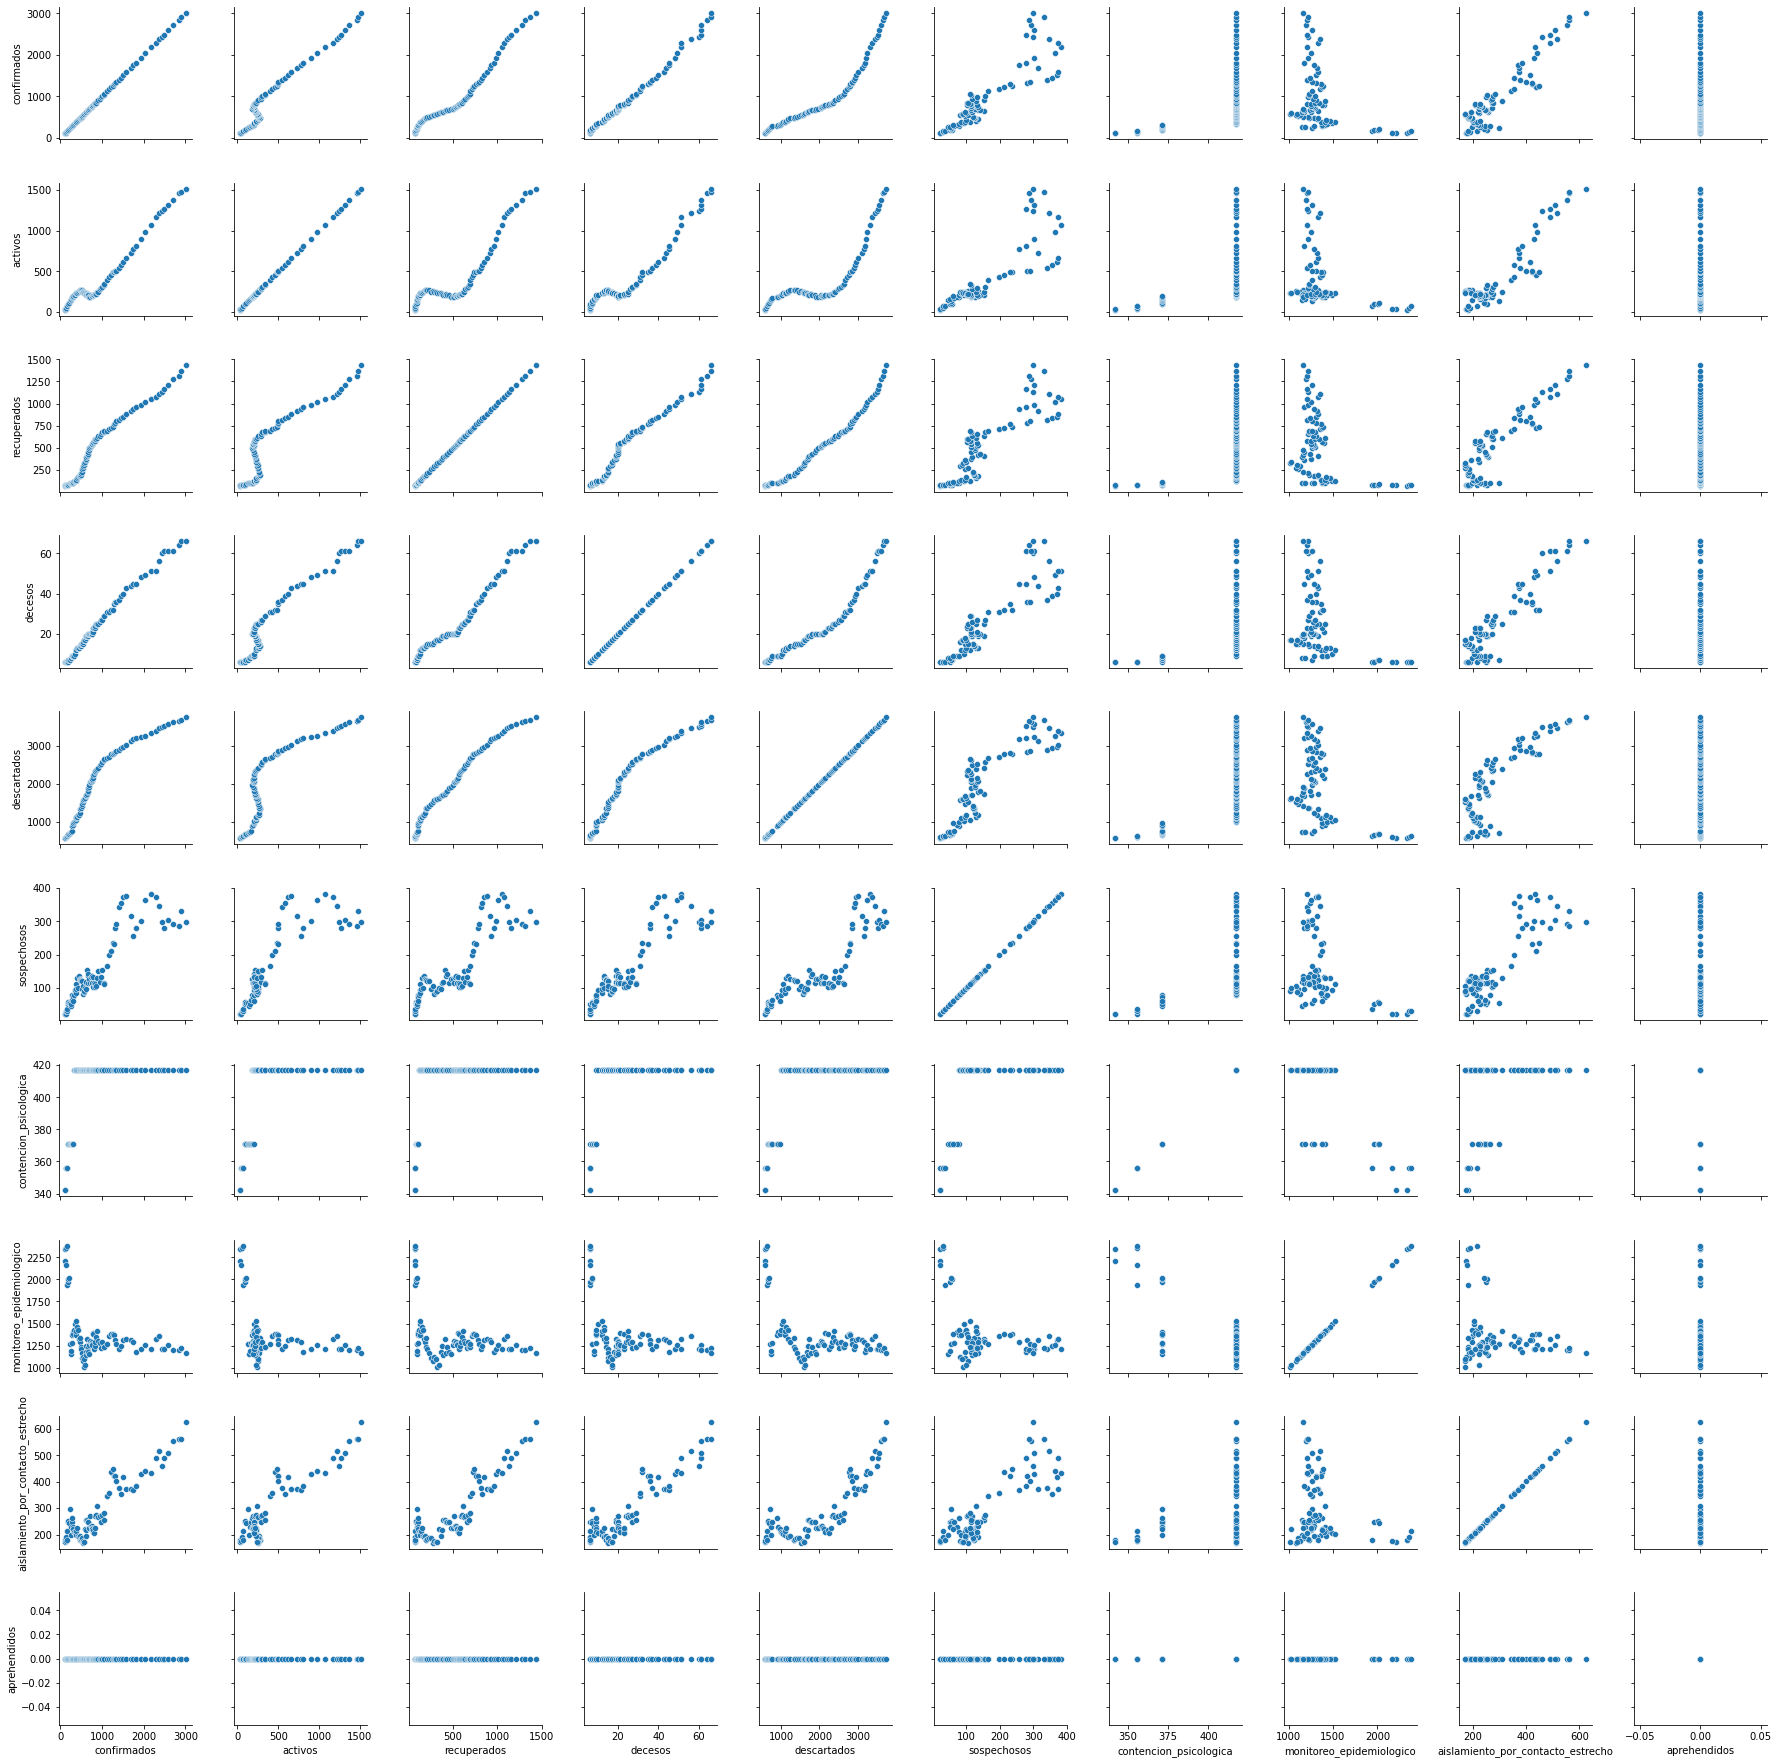

In [ ]:
#@title Scatterplots Dataset Casos
g = sns.PairGrid(df_casos)
g.map(sns.scatterplot)

Del scatterplot se observa una relación muy fuerte (casi determinística) entre las variables `confirmados`, `activos`, `recuperados`, `decesos` y `descartados`.
Las variables `aprehendidos` siempre vale cero, y `contención_psicológica` toma solo allgunos valores discretos.
La variable `monitoreo_epidemiológico `parece no tener una relación con ninguna otra variable. 

####Dataset Merge

In [ ]:
#@title Mezclar datasets mediante el index
df_merge = df_casos.merge(df_camas_clean, left_index=True, right_index=True)

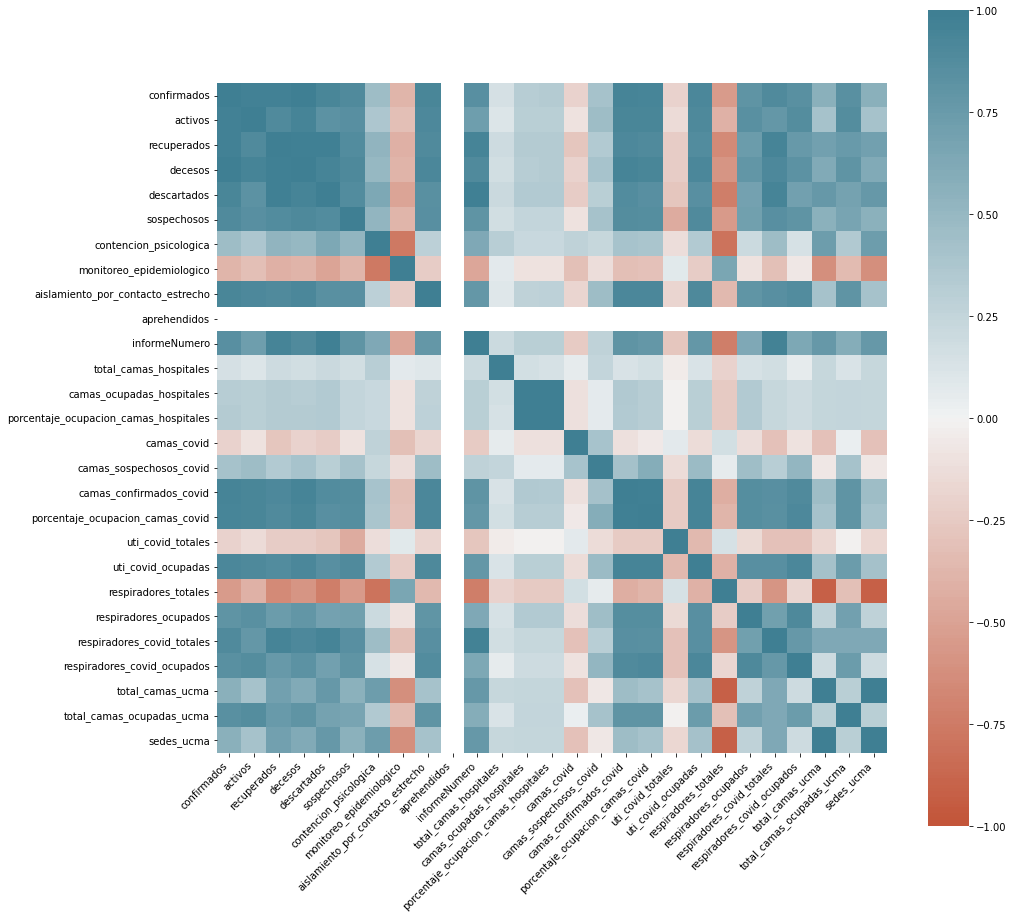

In [ ]:
#@title Correlacion Dataset Merge
corr = df_merge.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, xticklabels=True, yticklabels=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

fig = plt.gcf()
fig.set_size_inches(15, 15)

En la gráfica de arriba se observa:
* Una alta correlacion entre casos `confirmados`, `activos`, *recuperados*, `decesos`, `descartados`, `sospechosos` `aislamiento_por_contacto_estrecho` con `camas_confirmados_covid`, `respiradores_ocupados`, `respiradores_covid_totales`, `total_camas_ucma`, `sedes_ucma`.
* Correlacion negativa entre respiradores_totales con la mayoría de las variables restantes. 

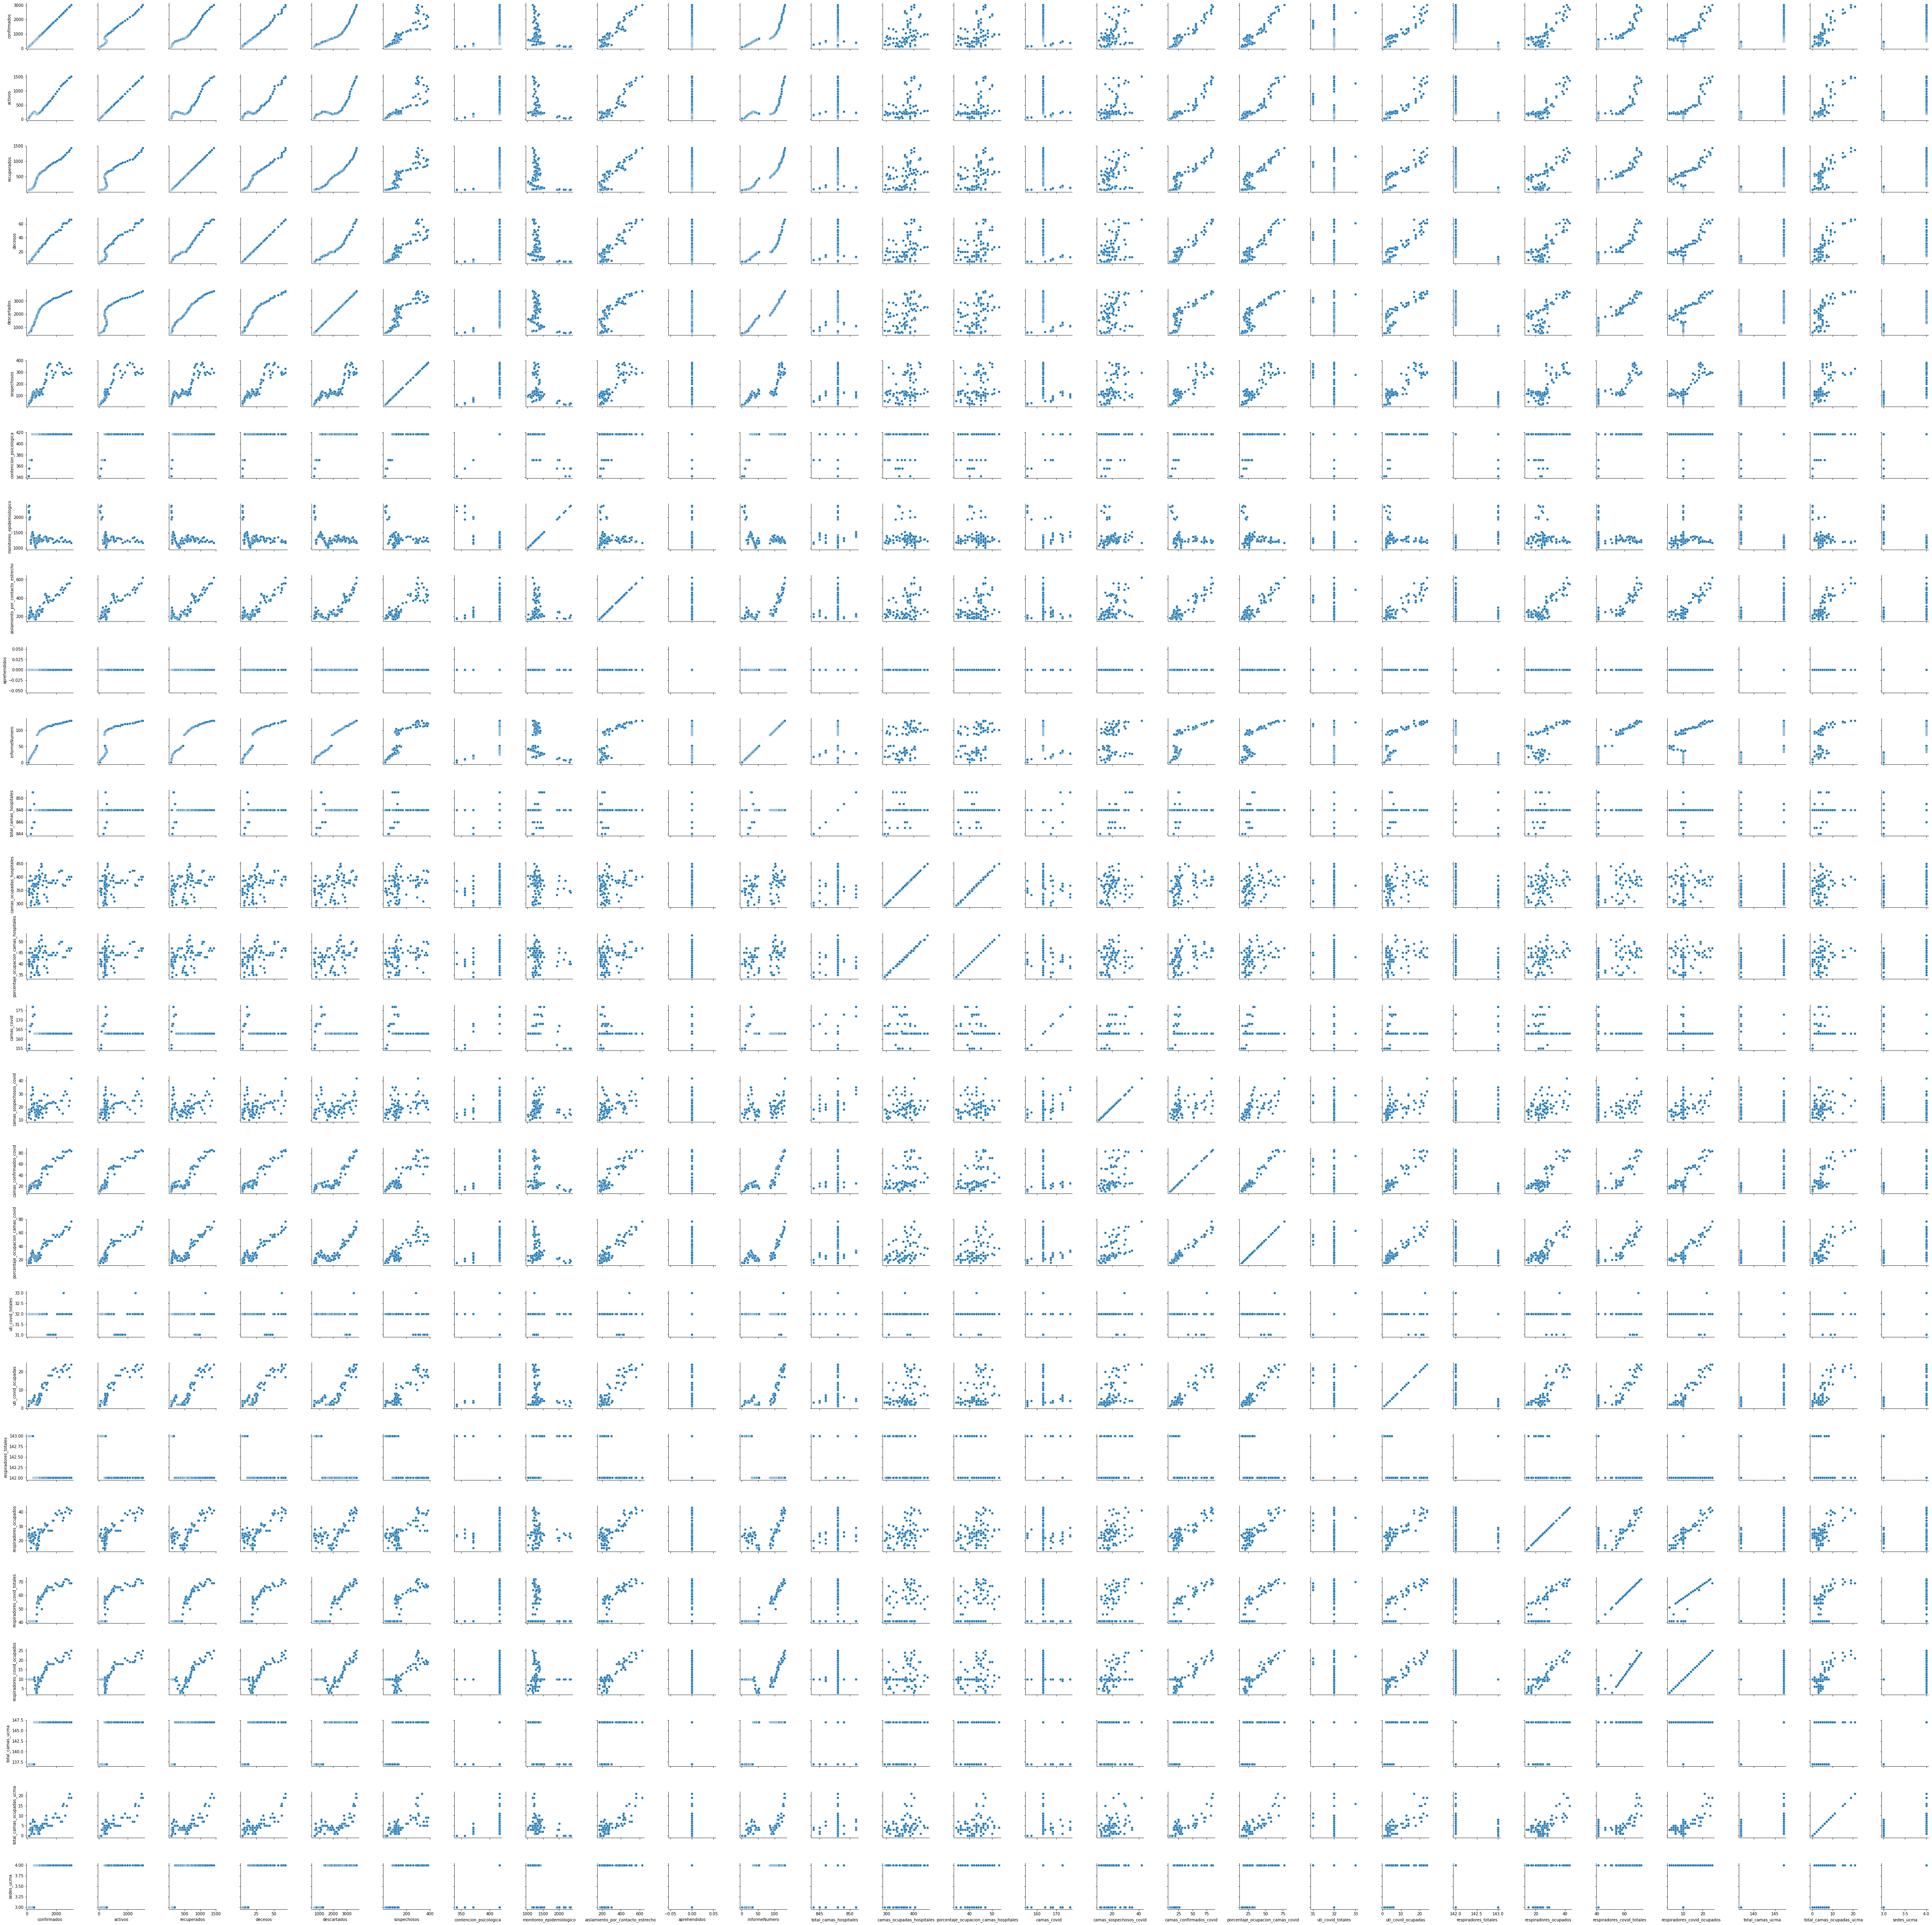

In [ ]:
#@title Scatterplots Dataset Merge
g = sns.PairGrid(df_merge)
g.map(sns.scatterplot)

##Ejercicio 2: Clasificadores
Generar un dataset de dos conjuntos Gaussianos con diferente media y DS, N=50 c/u, uno con etiqueta A y otro con etiqueta B.

Utilizar la curva ROC para proponer un umbral para un clasificador
por mínimo error. Evaluar algunos de los parámetros de calidad
(exactitud, precisión, f-measure).

Recalcular para algunas variantes (por ejemplo, acercando las
medias de los grupos A y B, cambiando el valor umbral, etc.).

Cómo podrían hacer no supervisado este proceso?

### Generacion de datos

Se crea una función para generar los datos. Toma como parámetros:

* `ns`: Tamaño total del dataset
* `meanA`: Media de población A
* `stdA`: Desvío estándar de población A
* `meanB`: Media de población B
* `stdB`: Desvío estándar de población B
* `sk`: Desbalance de datos. Si es 0.5, ambas poblaciones tienen la misma cantidad de muestras. Si es 0, sólo hay población B, y si es 1 sólo hay población A

Devuelve un DataFrame con dos columnas: `val` (valor) y `label` (clase 0: B , 1 :A)


In [ ]:
#@title Codigo: Generación de datos

def gen_data(ns=500, meanA=0.5, stdA= 1.0, meanB=-0.5, stdB= 1.0, sk = 0.5):

  # Generate datasets 
  dsA = list(np.random.normal(loc=meanA, scale=stdA, size=int(ns*sk)))
  dsB = list(np.random.normal(loc=meanB, scale=stdB, size=int(ns*(1-sk))))

  # Generate dataset labels
  lblA = [1 for i in range(len(dsA)) ]
  lblB = [0 for i in range(len(dsB)) ]
    
  # Create partial datasets
  dfA = pd.DataFrame(list(zip(dsA, lblA)), columns =['val', 'label'])
  dfB = pd.DataFrame(list(zip(dsB, lblB)), columns =['val', 'label'])

  # Join datasets, shuffle and reset indexes
  df = pd.concat([dfA, dfB], axis=0)
  df = df.sample(frac=1).reset_index(drop=True)

  # return dataframe
  return df


### Histograma

Se crea una función `plot_hist()` para graficar el histograma. Toma como parámetros:

* `df`: Un pd.Dataframe con los datos
* `ax`: Handle a axes matplotlib 

Por otro lado, se crea `plot_hist_th()` para agregar una línea vertical en el umbral de descisión. Parámetros:

* `th`: Valor del umbral
* `ax`: Handle a axes matplotlib
* `color`: Color de la línea
* `label`: Descripción para la referencia


In [ ]:
#@title Código: Histogram

def plot_hist(df: pd.DataFrame, ax=None):

  # If not specified, get current axis
  if ax is None:
    ax=plt.gca()

  # Create 100 bins frm -5 to 5
  bins = np.linspace(-5, 5, 100)

  ax.hist(df.loc[df['label']==1]['val'], bins, alpha=0.7, label='Population A')
  ax.hist(df.loc[df['label']==0]['val'], bins, alpha=0.7, label='Population B')
  ax.legend(loc='upper right')


def plot_hist_th(th, ax=None, color = None, label = None):

  # If not specified, get current axis
  if ax is None:
    ax=plt.gca()

  # If no color specified, force next color in cycle
  if color is None:
    color = next(ax._get_lines.prop_cycler)['color']

  if label is None:
    label = 'Threshold: '

  # Get axis ylim
  ylim=ax.get_ylim()

  # Plot Line
  ax.plot([th,th],[ylim[0],ylim[1]],'--',color = color, label=label+f': {th:.2f}')
  


### Métricas

Se crea la función `get_metrics(df)` que toma como parámetro el dataframe `df`, y devuelve por un lado una lista de thresholds (`ths`), y por otro un diccionario con las siguientes claves:

* `accs`: Lista de accuracies
* `precisions`: Lista de Precisions
* `recalls`: Lista de Recalls
* `fscores`: Lista de F-Scores
* `tprs`: Lista de TPRs
* `fprs`: Lista de FPRs


In [ ]:
#@title Código: Métricas

def get_metrics(df):
  '''
  Takes a dataframe as input and calculates a series of metrics for each possible threshold
  '''
  
  #Sort dataframe ascending 
  df_sorted = df.sort_values(by=['val']).reset_index(drop=True)

  # Dictionary to return metrics
  metrics = {}

  # Initialize lists for storing metrics
  metrics['accs'] = []
  metrics['precisions'] = []
  metrics['recalls'] = []
  metrics['fscores'] = []
  metrics['tprs'] = []
  metrics['fprs'] = []
  ths  = []

  # Iterate over label column of sorted dataset
  for i in range(len(df_sorted)):
    
    # Classified as positive
    df_p = df_sorted['label'].loc[i:]
    
    # Classified as negatives
    df_n = df_sorted['label'].loc[0:i]
    
    # True positives
    tp = (df_p == 1).sum()
    # False negatives
    fn = (df_n == 1).sum()
    # False Positives
    fp= (df_p == 0).sum() 
    # True Negatives
    tn= (df_n == 0).sum() 

    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn) 

    # True positive rate (recall)
    tpr = tp/(tp+fn)
    recall = tpr

    # False positive rate
    fpr = fp / (fp + tn)

    # Precision
    precision= tp/(tp+fp)

    # F-Score
    fscore = 2 * ( precision * recall ) / ( precision + recall)

    # Append to metrics
    metrics['accs'].append(acc)
    metrics['precisions'].append(precision)
    metrics['recalls'].append(recall)
    metrics['fscores'].append(fscore)
    metrics['tprs'].append(tpr)
    metrics['fprs'].append(fpr)
    ths.append(df_sorted['val'].loc[i])

  return ths,metrics


### Umbral óptimo

Se crea la función `find_opt_th_max()` que toma una lista de métricas `metrics` y una lista de thresholds `ths`, y devuelve la métrica máxima y el umbral correspondiente. Se utiliza para encontrar el umbral óptimo tanto para Accuracy como para F-Score

Por otro lado la función find_opt_th_roc() toma una lista de False Positive Rates `fprs`, una de True Positive Rates `tprs` y Thresholds asociados.
devuelve una terna `(fpr,tpr,th)` que corresponden al punto de operación óptimo en la curva ROC. Ese punto se corresponde al par `(fpr,tpr)` cuya diferencia `diff=tpr-fpr` es máxima. Esto es equivalente a encontrar la recta de pendiente 1 que es superior a todos los puntos de la curva ROC, menos uno. En caso de haber más de un punto, se devuelve el primero encontrado. 

In [ ]:
#@title Código: Umbral óptimo

def find_opt_th_max(metrics,ths):
  '''
  Find maximum metric value
  '''
  
  # Get number of points in ROC curve
  N = len(ths)
  diff = []

  # Get index of max value
  imax = np.argmax(metrics)

  return metrics[imax],ths[imax]

def find_opt_th_roc(fprs,tprs,ths):
  '''
  Loops over points in ROC curve until it finds optimal value (maximum TPR-FPR)
  '''
  
  # Get number of points in ROC curve
  N = len(ths)
  diff = []

  for i,th in enumerate(ths):
    diff.append(tprs[i] - fprs[i])

  # Get index of max value
  imax = np.argmax(diff)

  return fprs[imax],tprs[imax],ths[imax]

###Gráficas de métricas y curva ROC

Se crea la función `plot_metrics()` que toma como parámetro la lista de umbrales `ths` el diccionario de métricas `metrics` y grafica las métricas (Accuracy, Precision, Recall, F-Score) en función de los umbrales. Además encuentra los puntos máximos de Accuracy y F-Score y los marca con líneas verticales.

Por otro lado, la función `plot_roc()` grafica la curva ROC, encuentra el punto de operación óptimo y 



In [ ]:
#@title Código: Gráficas de métricas y curva ROC

def plot_metrics(ths,metrics,ax=None):
  '''
  Plots the metrics curve against the thresholds
  '''

  # If not specified, get current axis
  if ax is None:
    # Get axis handle
    ax = plt.gca()

  # Precision
  ax.plot(ths, metrics['precisions'],label = 'precision')
  
  # Recall
  ax.plot(ths, metrics['recalls'],label = 'recall')

  # F-score
  ax.plot(ths, metrics['fscores'],label = 'fscore', color = 'C3')

  # Maximum F-score
  f_score,th_f = find_opt_th_max(metrics['fscores'],ths)
  ax.plot([th_f,th_f],[f_score,f_score],'o',color = 'C3')

  ax.set_xlabel('Threshold')

  # Accuracies
  acc,th_acc = find_opt_th_max(metrics['accs'],ths)
  ax.plot([th_acc,th_acc],[acc,acc],'o',color = 'C7')

  ax.plot(ths, metrics['accs'],label = 'accuracy', color = 'C7' )
    
def plot_th_line_roc(fpr,tpr,th,ax=None):
  '''
  Plots decision line for given paramentes
  '''

  # If not specified, get current axis
  if ax is None:
    ax=plt.gca()

  # Force same color in both plots
  color = next(ax._get_lines.prop_cycler)['color']
  
  # Plot Line
  ax.plot([0,1],[tpr-fpr,1+tpr-fpr], label = 'th: ' + str(th),color='C6')
  
  # Plot Point
  ax.plot([fpr,fpr], [tpr,tpr], 'o',color='C6')

def plot_roc(fprs,tprs,ths,ax=None):
  '''
  Plots the ROC curve given FPR and TPR lists
  If a threshold is given, plot it, otherwise calculate optimal automatically
  '''

  # If not specified, get current axis
  if ax is None:
    # Get figure and axis handle
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = plt.gca()

  # Plot ROC Curve  
  ax.plot(fprs,tprs)

  # Find optimal th
  fpro,tpro,tho = find_opt_th_roc(fprs,tprs,ths)

  # Plot optimal decision line
  plot_th_line_roc(fpro,tpro,tpro,ax)

  # Plot random decision line
  ax.plot([0,1], [0,1], 'k--', alpha=0.5, zorder=0)
  
  # Title and labels
  ax.set_title('ROC Curve')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  ax.set_xlim([0,1.001])
  ax.set_ylim([0,1.001])
  ax.legend( loc='lower right')



### Gráfico Interactivo

Se crea un gráfico interactivo donde se pueden variar parámetros del sistema: número de muestras, parámetros de las distribuciones de ambas poblaciones y el desbalance de datos.
En el primer gráfico se muestra el histograma de ambas distribuciones, con los umbrales seleccionados por cada método: Accuracy, F-Score y Curva ROC. En el segundo se muestran las métricas Accuracy,  Precision, Recall y F-score. En el tercero se muestra la curva ROC (TPR en funcion de FPR), junto con el punto de operación óptimo.

Se observa que al acercar las medias (meanA = meanB = 0, stdA = stdB = 1) las curvas de Accuracy, F-Score se van aplanando, desdibujándose el punto óptimo. La curva ROC tiende a igualar a la TPR=FPR (Desición Aleatoria). Sucede algo similar si las variazas aumentan. (meanA = 1, meanB = -1, stdA = stdB = 2). 
En cualquier caso los puntos óptimos seleccionados por cada métrica comienzan a diferir, en forma aleatoria.

Text(0.5, 1.0, 'ROC Curve\nth roc=0.29 tpr=0.81 fpr=0.09')

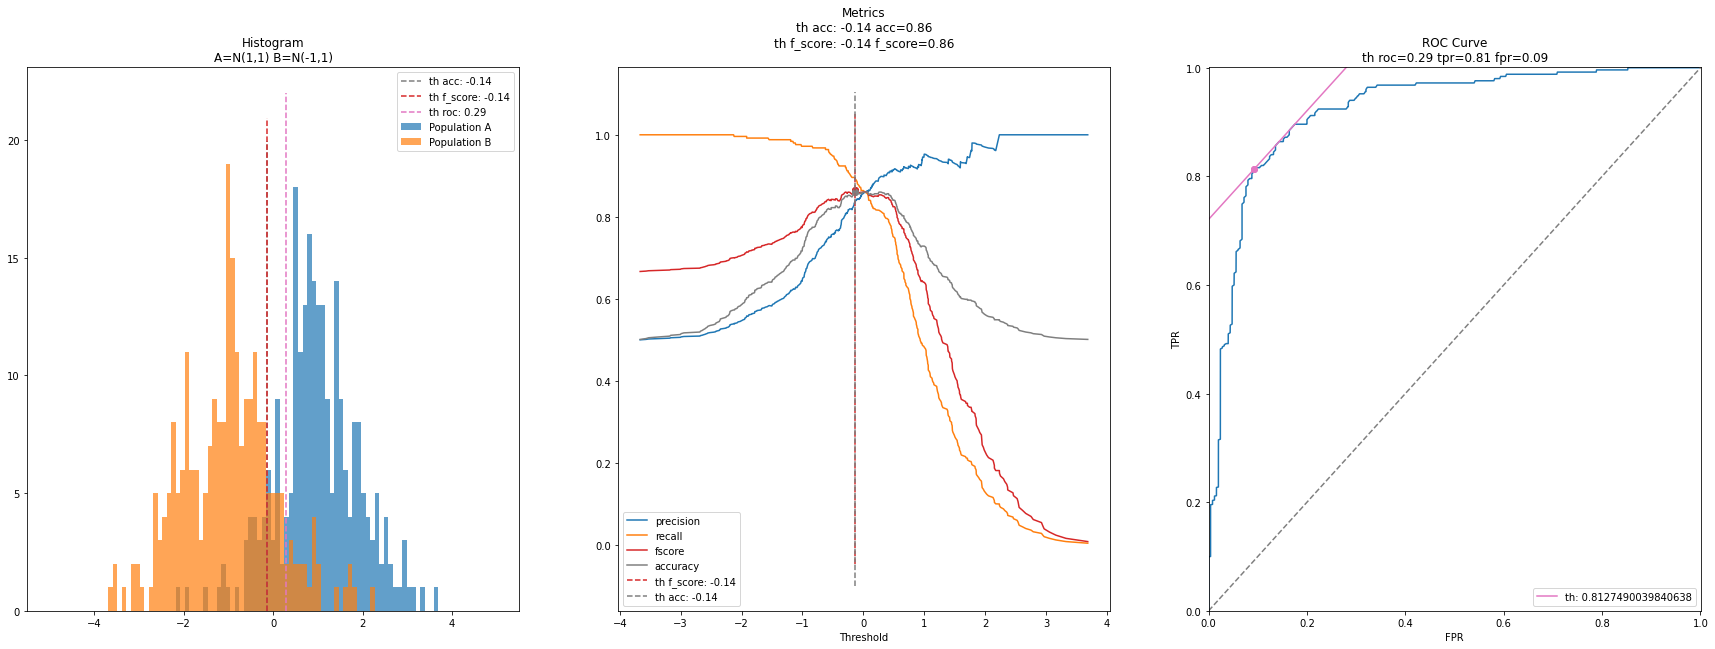

In [ ]:
#@title { run: "auto" }
#@markdown Select number of samples
ns = 500 #@param {type:"slider", min:0, max:500, step:10}
#@markdown Population A
meanA = 1 #@param {type:"slider", min:-2, max:2, step:0.1}
stdA = 1 #@param {type:"slider", min:0.5, max:2, step:0.1}
#@markdown Population B
meanB = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
stdB = 1 #@param {type:"slider", min:0.5, max:2, step:0.1}
#@markdown Data skew (0.5: Balanced , 0: Only B, 1: Only A)
sk = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Generate data
df = gen_data(ns, meanA, stdA, meanB, stdB, sk)

# Get metrics
ths, metrics = get_metrics(df)

# Calculate optimal threshold from ROC curve
fpr,tpr,th_roc = find_opt_th_roc(metrics['fprs'],metrics['tprs'],ths)
f_score,th_f = find_opt_th_max(metrics['fscores'],ths)
acc,th_acc = find_opt_th_max(metrics['accs'],ths)

# Set figure properties
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(30,10)

# Plot Histogram
plot_hist(df,axes[0])
# Plot thresholds
plot_hist_th(th_f,ax=axes[0], color = 'C7', label = 'th acc')
plot_hist_th(th_f,ax=axes[0], color = 'C3', label = 'th f_score')
plot_hist_th(th_roc,ax=axes[0], color = 'C6', label = 'th roc')
axes[0].set_title('Histogram'+'\nA=N('+str(meanA)+','+str(stdA)+')'+' B=N('+str(meanB)+','+str(stdB)+')')
axes[0].legend()

# Plot Metrics (Precision, Recall, F-Score)
plot_metrics(ths,metrics,axes[1])
plot_hist_th(th_f,ax=axes[1], color = 'C3', label = 'th f_score')
plot_hist_th(th_acc,ax=axes[1], color = 'C7', label = 'th acc')
axes[1].set_title('Metrics\n'+f'th acc: {th_acc:.2f}'+' '+'acc='+f'{acc:.2f}\n'+f'th f_score: {th_f:.2f}'+' '+'f_score='+f'{f_score:.2f}\n')
axes[1].legend()

# Plot ROC
plot_roc(metrics['fprs'],metrics['tprs'],ths,axes[2])
axes[2].set_title('ROC Curve'+'\nth roc='+f'{th_roc:.2f}'+' '+'tpr='+f'{tpr:.2f}'+ ' '+ 'fpr='+f'{fpr:.2f}')
